# Bay Wheels Data Exploration

## Preliminary Wrangling
This document explores a dataset of 176799 trips using Bay Wheels bikes. 

In [101]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
import datetime

%matplotlib inline

#### Define
    - Convert data strings to data type.
    - Calculate and add column with the distance in Km. 
    - Calculate and add column with the pace in Km/h. 
    - Calculate and add column with the duration in minutes.

In [112]:
df = pd.read_csv('202003-baywheels-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,35187,2020-03-31 20:42:10.0790,2020-04-01 06:28:37.8440,462.0,Cruise Terminal at Pier 27,37.804648,-122.402087,24.0,Spear St at Folsom St,37.789677,-122.390428,10982,Customer,NaN
1,14568,2020-03-31 22:45:25.5010,2020-04-01 02:48:13.7730,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN
2,35990,2020-03-31 15:08:22.3310,2020-04-01 01:08:12.9900,391.0,1st St at Younger Ave,37.355030,-121.904436,397.0,Gish Rd at 1st St,37.361867,-121.909315,12812,Customer,NaN
3,1068,2020-03-31 23:55:00.4260,2020-04-01 00:12:49.0200,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN
4,3300,2020-03-31 23:00:55.6410,2020-03-31 23:55:56.6110,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             176799 non-null  int64  
 1   start_time               176799 non-null  object 
 2   end_time                 176799 non-null  object 
 3   start_station_id         110696 non-null  float64
 4   start_station_name       111349 non-null  object 
 5   start_station_latitude   176799 non-null  float64
 6   start_station_longitude  176799 non-null  float64
 7   end_station_id           111097 non-null  float64
 8   end_station_name         111794 non-null  object 
 9   end_station_latitude     176799 non-null  float64
 10  end_station_longitude    176799 non-null  float64
 11  bike_id                  176799 non-null  int64  
 12  user_type                176799 non-null  object 
 13  rental_access_method     114269 non-null  object 
dtypes: f

In [116]:
# Make a clean copy of the original dataframe
df_clean = df.copy()

# Convert start_time and end_time columns to datetime
df_clean['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
df_clean['end_time'] = pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S.%f')

# Test 
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             176799 non-null  int64         
 1   start_time               176799 non-null  datetime64[ns]
 2   end_time                 176799 non-null  datetime64[ns]
 3   start_station_id         110696 non-null  float64       
 4   start_station_name       111349 non-null  object        
 5   start_station_latitude   176799 non-null  float64       
 6   start_station_longitude  176799 non-null  float64       
 7   end_station_id           111097 non-null  float64       
 8   end_station_name         111794 non-null  object        
 9   end_station_latitude     176799 non-null  float64       
 10  end_station_longitude    176799 non-null  float64       
 11  bike_id                  176799 non-null  int64         
 12  user_type       

In [115]:
df_clean.rental_access_method.unique()

array([nan, 'app', 'clipper'], dtype=object)

In [114]:
df_clean.user_type.unique()

array(['Customer', 'Subscriber'], dtype=object)

In [117]:
# Distance covered in each trip

# Radius of the Earth
R = 6373.0

distance = []

for index, row in df_clean.iterrows(): 
    lat1 = math.radians(row['start_station_latitude'])
    lon1 = math.radians(row['start_station_longitude'])
    lat2 = math.radians(row['end_station_latitude'])
    lon2 = math.radians(row['end_station_longitude'])

    dlon = lon2 - lon1

    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in Km
    distance.append(R * c)

df_clean['distance_km'] = distance



In [118]:
# Remove duration larger than 18.000 seconds 
print('Before: ', df_clean['duration_sec'].describe())

remove_dur = df_clean.query('duration_sec > 18000')

df_clean = df_clean[~df_clean.index.isin(remove_dur.index)]

# Test
print('After: ', df_clean['duration_sec'].describe())



Before:  count    176799.000000
mean        861.590156
std        1528.143090
min          60.000000
25%         374.000000
50%         602.000000
75%         963.000000
max       84450.000000
Name: duration_sec, dtype: float64
After:  count    176657.000000
mean        830.424438
std         897.790517
min          60.000000
25%         374.000000
50%         602.000000
75%         962.000000
max       17974.000000
Name: duration_sec, dtype: float64


In [119]:
# Pace of each trip.
pace = []

df_clean['distance_km'] = df_clean['distance_km'].astype(float)

# Convert duration from seconds to minuted and to hours. 
for index, row in df_clean.iterrows(): 
    time_hours = ((row['duration_sec']/60)/60)    
    distance = row['distance_km']
    # Calculate the pace
    
    pace.append(distance/time_hours)

df_clean['pace_km_h'] = pace

df_clean['pace_km_h'].describe()

count    176657.000000
mean         11.389696
std         273.778693
min           0.000000
25%           7.544820
50%          10.301328
75%          12.773600
max       73380.636281
Name: pace_km_h, dtype: float64

In [121]:
# Duration in minutes 

df_clean['duration_min'] = df_clean['duration_sec']/60

In [122]:
df_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,distance_km,pace_km_h,duration_min
1,14568,2020-03-31 22:45:25.501,2020-04-01 02:48:13.773,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN,1.058744,0.261634,242.800000
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,3.504582,11.813196,17.800000
4,3300,2020-03-31 23:00:55.641,2020-03-31 23:55:56.611,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN,2.021190,2.204935,55.000000
5,1232,2020-03-31 23:29:19.395,2020-03-31 23:49:52.252,152.0,47th St at San Pablo Ave,37.835632,-122.281051,195.0,Bay Pl at Vernon St,37.812314,-122.260779,9746,Customer,NaN,3.146346,9.193869,20.533333
6,368,2020-03-31 23:35:03.834,2020-03-31 23:41:12.221,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,70.0,Central Ave at Fell St,37.773311,-122.444293,11057,Customer,NaN,1.441416,14.100806,6.133333


## Exploratory Analysis

### What is the structure of your dataset?
There are a total of 176.799 trips records. For each trip, we have the information of the time, stations, bicycle used, and, user information. The user can be a customer or subscriber. The trip duration is given in seconds. Each trip has start and end stations and, for each station, the latitude, longitude, name, and id information are provided. The rental access method could be via an app, clipper, or not available. I've added two columns, distance in kilometers, calculated using the Haversine formula and the pace. 

### What is/are the main feature(s) of interest in your dataset?
The distances and the time are the main features in the dataset. With this information, we can verify some patterns between bike users. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
The latitude and longitude of both the start and end stations could give us the distance. Using the distance with the time in seconds, we could verify if members, subscribed users, are faster than casual users, for example.  

### Univariate Exploration

In [178]:
# Make a clean copy of the preliminary wrangled database
df_clean_eda = df_clean.copy()

#### Categorical Variables 

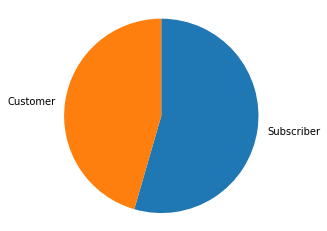

In [179]:
# Piechart user_type

sorted_counts = df_clean_eda['user_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False);
plt.axis('square');

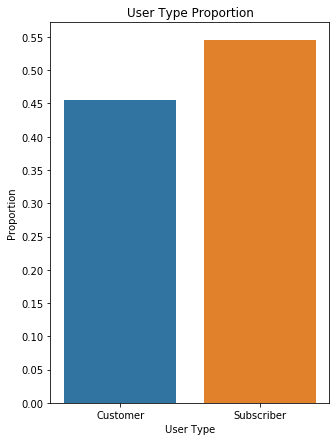

In [180]:
# Barchart user_type proportion

n = df_clean_eda.shape[0]
max_count = df['user_type'].value_counts().max()
max_prop = max_count / n

# Tick mark locations
tick_props = np.arange(0, 1, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

def graph_user_type():
    sb.countplot(data = df_clean_eda, x = 'user_type'); 
    plt.xlabel('User Type')
    plt.ylabel('Proportion')
    plt.title('User Type Proportion')

plt.figure(figsize=[5,7])
plt.yticks(tick_props * n, tick_names)

graph_user_type()

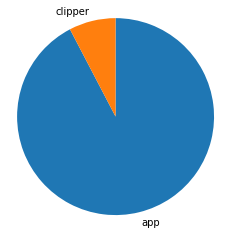

In [181]:
# Piechart rental_access_method

sorted_counts = df_clean_eda['rental_access_method'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False);
plt.axis('square');

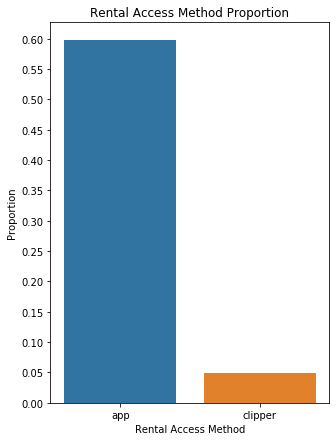

In [182]:
# Barchart rental_access_method proportion

n = df_clean_eda.shape[0]
max_count = df['rental_access_method'].value_counts().max()
max_prop = max_count / n

# Tick mark locations
tick_props = np.arange(0, 1, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

def graph_user_type():
    sb.countplot(data = df_clean_eda, x = 'rental_access_method'); 
    plt.xlabel('Rental Access Method')
    plt.ylabel('Proportion')
    plt.title('Rental Access Method Proportion')

plt.figure(figsize=[5,7])
plt.yticks(tick_props * n, tick_names)

graph_user_type()

The proportions in the rental access method, show us that almost 60% of the rentals are via the app, and only 5% via clipper. The rest are not identified and we will not remove those in this analysis. 

# Retirar antes de enviar ou tentar montar o gráfico

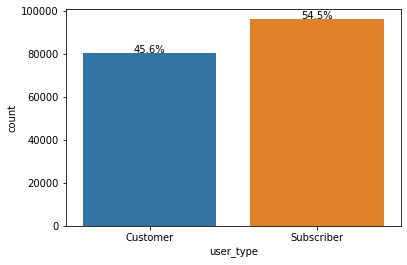

In [80]:
# barchart - categorical variables - proportions with %

sb.countplot(data = df_clean, x = 'user_type'); 
    
n = df_clean.shape[0]
user_count = df['user_type'].value_counts()
locs, labels = plt.xticks()

for loc, label in zip(locs, labels):
    count = user_count[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n)
    
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black')
    

#### Quantitative Variables

##### Distances

In [183]:
# Verify distances values before plotting

df_clean_eda['distance_km'].describe()

count    176657.000000
mean          2.285372
std          74.589443
min           0.000000
25%           0.901365
50%           1.543855
75%           2.513332
max       12800.844329
Name: distance_km, dtype: float64

We can verify that some distances are equal to zero, and some distances are way too large. So we will remove distances smaller than 50 meters, a person can walk this distance, and larger than 25 km which seems to be too much for a rented bike ride. 

In [184]:
# Remove distances equal to zero. 
print('Before:', df_clean_eda['distance_km'].describe())

remove_dist = df_clean_eda.query('distance_km < 0.05 or distance_km > 25')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_dist.index)]

# Test
print('After:', df_clean_eda['distance_km'].describe())


Before: count    176657.000000
mean          2.285372
std          74.589443
min           0.000000
25%           0.901365
50%           1.543855
75%           2.513332
max       12800.844329
Name: distance_km, dtype: float64
After: count    169151.000000
mean          1.932256
std           1.317551
min           0.050053
25%           0.977250
50%           1.608040
75%           2.569324
max          22.383799
Name: distance_km, dtype: float64


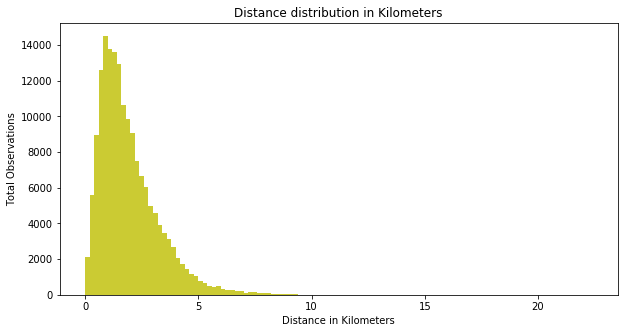

In [139]:
# Verify how the distances are distributed after assessing and cleaning.

binsize = 0.2
bins = np.arange(0, df_clean_dist['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_dist, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Distance distribution in Kilometers')    
plt.ylabel('Total Observations')
plt.xlabel('Distance in Kilometers')


plt.show(graph());

From plotting again, it is clear that the distribution is right-skewed, with almost all the values between 0 and 5 m. We will plot again with a limit of 10 km to take a closer look at the majority of observations.

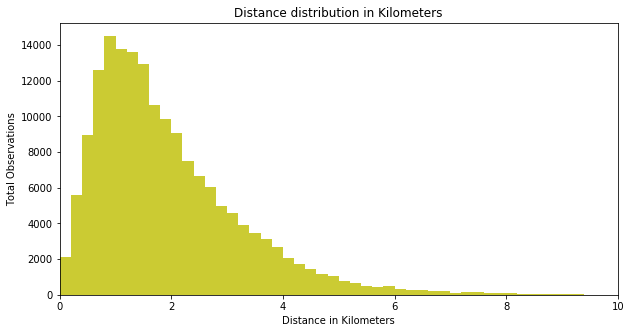

In [185]:
# Verify how the distances are distributed after assessing and cleaning with 10 km limit. 

binsize = 0.2
bins = np.arange(0, df_clean_eda['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Distance distribution in Kilometers')  
plt.ylabel('Total Observations')
plt.xlabel('Distance in Kilometers')
plt.xlim([0, 10])

plt.show(graph());

Let's shrink even more and look at the values between 0 km and 2 km.


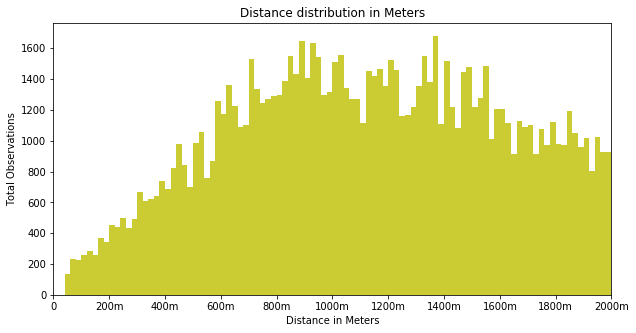

In [186]:
# Verify how the distances are distributed after assessing and cleaning with 2 km limit. 

binsize = 0.02
bins = np.arange(0, df_clean_eda['distance_km'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='y', x = 'distance_km', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Distance distribution in Meters')  
plt.ylabel('Total Observations')
plt.xlabel('Distance in Meters')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2],['0', '200m', '400m', '600m', '800m', '1000m', '1200m', '1400m', '1600m', '1800m', '2000m'])
plt.xlim([0, 2])

plt.show(graph());

From this visualization, we can verify that the most common distance biked by the users is between 800m and 1400m. 

##### Time

In [151]:
# Verify trip duration values before plotting

df_clean_eda['duration_min'].describe()

count    169151.000000
mean         13.268174
std          13.543520
min           1.000000
25%           6.283333
50%           9.950000
75%          15.633333
max         299.566667
Name: duration_min, dtype: float64

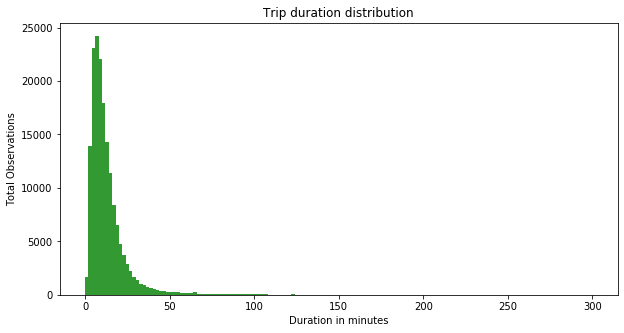

In [187]:
# Verify how the time in minutes is distributed

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Trip duration distribution')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')

plt.show(graph());

From plotting the distribution of the time per trip, we can see that some values are longer than 3 hours, which seems a bit too much. We will remove those values and plot.

In [202]:
# Remove duration over 3 hours or 160 minutes. 

print('Before:', df_clean_eda['duration_min'].describe())

remove_time = df_clean_dist.query('duration_min > 160')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_time.index)]

# Test
print('After:', df_clean_eda['distance_km'].describe())


Before: count    159997.000000
mean         11.671273
std           8.529555
min           1.000000
25%           6.133333
50%           9.600000
75%          14.716667
max         155.833333
Name: duration_min, dtype: float64
After: count    159997.000000
mean          1.991406
std           1.313574
min           0.057388
25%           1.034024
50%           1.669950
75%           2.629087
max          20.852021
Name: distance_km, dtype: float64


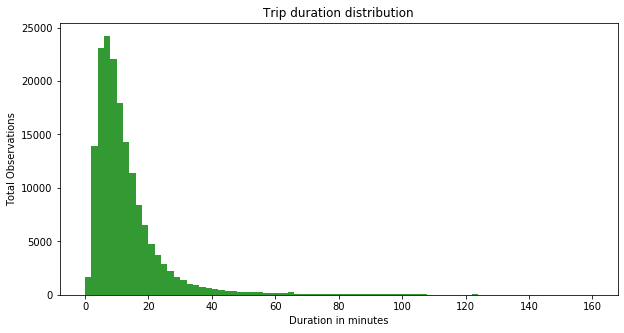

In [192]:
# Verify how the time in minutes is distributed after removing values over 4 hours

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Trip duration distribution')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')

plt.show(graph());

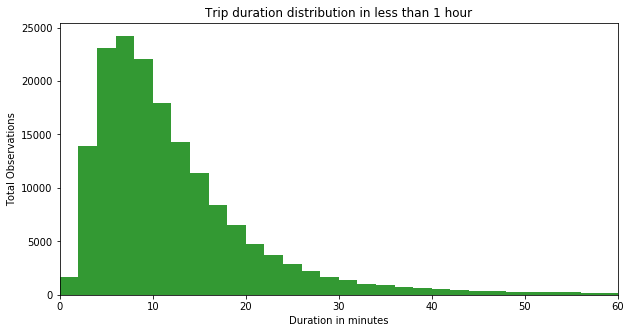

In [189]:
# Verify how the time in minutes is distributed

binsize = 2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Trip duration distribution in less than 1 hour')    
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 60])

plt.show(graph());

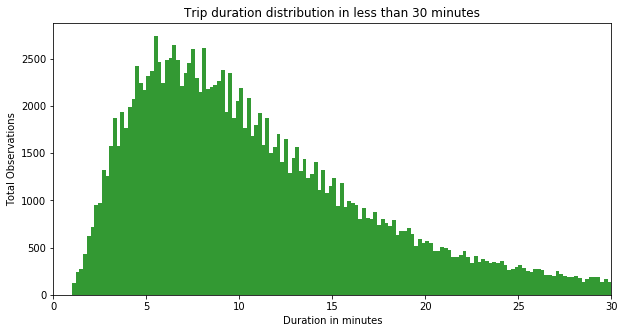

In [190]:
# Verify how the distances are distributed after assessing and cleaning with 2 km limit. 

binsize = 0.2
bins = np.arange(0, df_clean_eda['duration_min'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.8, facecolor='g', x = 'duration_min', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Trip duration distribution in less than 30 minutes')  
plt.ylabel('Total Observations')
plt.xlabel('Duration in minutes')
plt.xlim([0, 30])

plt.show(graph());

From the detailed distribution above, it is possible to see that after 10 minutes, the number of observations starts to decrease. People tend to spend between 5 and 10 minutes of biking. 

In [191]:
df_clean_eda['pace_km_h'].describe()

count    169003.000000
mean         10.319030
std           3.957514
min           0.034432
25%           8.009407
50%          10.510836
75%          12.901727
max         113.837167
Name: pace_km_h, dtype: float64

From the table above, we can verify that the maximum pace is 113 km/h which is impossible to be achieved when biking. We will consider 30 km/h the maximum pace considering it is a normal bicycle and normal cyclists. 

In [193]:
# Remove pace records over 30 km/h

print('Before:', df_clean_eda['pace_km_h'].describe())

remove_pace = df_clean_dist.query('pace_km_h > 30')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_pace.index)]

# Test
print('After:', df_clean_eda['pace_km_h'].describe())


Before: count    169003.000000
mean         10.319030
std           3.957514
min           0.034432
25%           8.009407
50%          10.510836
75%          12.901727
max         113.837167
Name: pace_km_h, dtype: float64
After: count    169000.000000
mean         10.318143
std           3.948710
min           0.034432
25%           8.009388
50%          10.510825
75%          12.901585
max          26.428188
Name: pace_km_h, dtype: float64


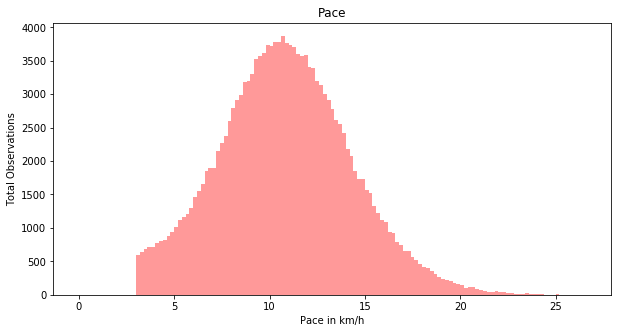

In [201]:
# Verify how the pace is distributed

binsize = 0.2
bins = np.arange(0, df_clean_eda['pace_km_h'].max()+binsize, binsize)

def graph():
    plt.hist(data = df_clean_eda, alpha=0.4, facecolor='r', x = 'pace_km_h', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Pace')    
plt.ylabel('Total Observations')
plt.xlabel('Pace in km/h')

plt.show(graph());

The pace is a normal distribution, different from distance and time. From the plot, we can also verify that there are some pace values below 3 km/h which is walking speed. Those might be users that took the bike but for whatever reason walked the bike until the destination station. We can remove those users. 

In [199]:
# Remove pace records over 30 km/h

print('Before:', df_clean_eda['pace_km_h'].describe())

remove_pace = df_clean_dist.query('pace_km_h < 3')

df_clean_eda = df_clean_eda[~df_clean_eda.index.isin(remove_pace.index)]

# Test
print('After:', df_clean_eda['pace_km_h'].describe())


Before: count    159997.000000
mean         10.812180
std           3.442148
min           3.000725
25%           8.480987
50%          10.739332
75%          13.049928
max          26.428188
Name: pace_km_h, dtype: float64
After: count    159997.000000
mean         10.812180
std           3.442148
min           3.000725
25%           8.480987
50%          10.739332
75%          13.049928
max          26.428188
Name: pace_km_h, dtype: float64


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations? ###
There were some unusual points in the data like distances too large to be covered by bike and, some biking times were also too large to be true and some were equal to zero. For the zero ones, my best assumption is that the person rented a bike, had some problems, and ended up giving the bike back or some other issue with the system. I also added two new columns to represent the distance, calculated using latitude and longitude, and the user's pace. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this? ###

Firstly, I defined what operations were needed to tidy and adjust the data. Starting from the distance in kilometers I removed distances smaller than 50 meters, a person can walk this distance, and larger than 25 km which seems to be too much for a rented bike ride. Secondly, I removed trip duration records longer than 3 hours. When checking the pace, I found large values, too large to be achieved by biking and walking paces. Those extreme values were also removed.